# Plot within-gene mutation spectra and coverages

Useful for comparing genes.

In [1]:
%run "Header.ipynb"

In [2]:
import time
import pileup
from parse_sco import parse_sco

In [3]:
t0 = time.time()
seq2pos2pileup = pileup.load()
t1 = time.time()
print(f"Loaded pickled pileup file in {t1 - t0:,.2f} sec.")

Loaded pickled pileup file in 10.76 sec.


## Define utility functions for plotting

In [4]:
def init_cp(strand):
    """Returns the CP of the leftmost position in a gene. Arguably too simple for its own good."""
    if strand == "+":
        return 1
    else:
        return 3

def move_cp_right(cp, strand):
    """Moves a given CP value right by 1. This is really just basic modulo arithmetic, but I wrote
       it out very explicitly to make this easier to read.
    """
    if strand == "+":
        if cp == 3:
            return 1
        else:
            return cp + 1
    else:
        if cp == 1:
            return 3
        else:
            return cp - 1
        
def get_label(p, cp, leftend, strand):
    """Defines the label we assign to a given point in a mutation spectrum / coverage plot.
    
    This label, in turn, impacts the legend shown by matplotlib.
    """
    formatcp = lambda n: "Codon Position {}".format(n)
    
    # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
    # To avoid this, we just only assign labels to the first point of CP 1, then the first point
    # of CP 2, then the first point of CP 3 -- so the legend only has the three unique colors, as desired.
    # See https://stackoverflow.com/a/19386045.
    if strand == "+":
        # For positive-strand genes, we can just take the first three points (going from left to right)'s
        # labels -- these will have labels CP 1, 2, 3.
        return "" if (p - leftend >= 3) else formatcp(cp)
    else:
        # For negative-strand genes, life is a bit harder. We could just take the first three points,
        # similarly to how positive-strand genes are handled above, but the problem with this is that
        # matplotlib is sensitive to label orderings... so then the label is flipped, and CP 3 is shown
        # first, then CP 2, then CP 1. Which is not desirable.
        #
        # We correct this by noting that the earliest occurrence of CP 1 from the left is when
        # (p - leftend) == 2. The earliest occurrence of CP 2 after that is when (p - leftend == 4).
        # And the earliest occurrence of CP 3 after that is when (p - leftend == 6). We can thus set up
        # some simple-ish rules that'll let us extract the CP 1/2/3 labels in order.
        #
        # (The reason this uses >= 7 as the first conditional is so that we can fail quickly for
        # higher positions in the gene, using boolean short-circuiting.)
        #
        # (...I guess this will fail, producing legends without enough detail, if the gene doesn't have
        # at least 7 characters. I think that is not a very likely scenario, and it wouldn't be a very
        # big problem anyway.)
        return "" if (p - leftend >= 7 or (p - leftend) in [0, 1, 3, 5]) else formatcp(cp)

In [5]:
def plot_gene_mutation_spectrum(seq, leftend, rightend, strand, ax, cutoff=None):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    
    Returns ms_range, a string describing information about the range of mutation frequencies
    in this gene. Useful if we want to override the title set here (which we will want to do
    if including multiple mutation spectrum plots in the same figure).
    """
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")
        
    # Use strand to influence whether this goes 123123123 or 321321321
    cp = init_cp(strand)
    
    all_pcts = []
    
    num_called_mutations = 0
    called_mutations_in_cps = [0, 0, 0]
    called_mutations_pcts = []
    called_mutations_positions = []
    
    # We adopt the strategy here of calling .scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    
    for p in gene_positions:
        # Use the max-freq alternate nucleotide, to match our definition of freq(pos).
        pct = pileup.get_alt_nt_pct(seq2pos2pileup[seq][p])
        all_pcts.append(pct)
        
        label = get_label(p, cp, leftend, strand)
        
        bc = BORDERCOLOR
        # little test -- look for the two diff-strain (?) positions in CAMP
        if seq == "edge_6104" and (p == 986217 or p == 986215):
            bc = "#ff0000"
        ax.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=bc)
        
        cp = move_cp_right(cp, strand)

        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
            called_mutations_in_cps[cp - 1] += 1
            called_mutations_pcts.append(pct)
            called_mutations_positions.append(p)
    
    min_mutation_pct = min(all_pcts)
    max_mutation_pct = max(all_pcts)
    avg_mutation_pct = mean(all_pcts)
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))
        # Avoid printing details if no "mutations" were identified here -- mean() will throw an error, at least
        # as of writing, if passed an empty collection.
        if num_called_mutations > 0:
            print("{} mutations in CP 1; {} mutations in CP 2; {} mutations in CP 3.".format(*called_mutations_in_cps))
            print("Average mutation rate among these {} positions is {:.2f}%.".format(
                num_called_mutations, mean(called_mutations_pcts) * 100
            ))
            print("These exact positions are {}".format(called_mutations_positions))

    ms_range = (
        f"from {min_mutation_pct * 100:.2f}% to "
        f"{max_mutation_pct * 100:.2f}% (average = {avg_mutation_pct * 100:.2f}%)"
    )
    ax.set_title(f"Mutation Spectrum\nRanges {ms_range}")
    # https://stackoverflow.com/a/27474400 -- need to use raw string
    # https://stackoverflow.com/a/23856968 -- can use \mathrm{} to substitute for \text{}
    ax.set_ylabel(r"$\dfrac{\mathrm{Second\ Most\ Common\ Nucleotide\ Count}}{\mathrm{Mismatches + Matches}}$")
    
    # We could set the y-axis to stop at 0, but it's nice to show the entirety of each point (even ones at 0%)
    # ax.set_ylim(0)

    # Make low-mutation-rate genes have more granularity in the y-axis tick labels (matplotlib
    # can do stuff like just show 0% for all ticks if we use decimals=0)
    # The reason we don't use decimals=None, the default (where we make matplotlib pick the level of granularity),
    # is that that seems to use too many decimals for our purposes (the docs admit that decimals=None has some
    # limitations: https://github.com/matplotlib/matplotlib/blob/22258133da1fd25e38a519b8fe1314d1ba513990/lib/matplotlib/ticker.py#L1624-L1626)
    # This approach isn't perfect either, but it's good enough. (TODO: figure out the optimal way to do this?)
    if max_mutation_pct < 0.005:
        decimals = 2
    elif max_mutation_pct < 0.05:
        decimals = 1
    else:
        decimals = 0
        
    print("Maximum mutation rate is {:.2f}%".format(max_mutation_pct * 100))
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    ax.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=decimals))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(ax.get_xaxis())
    return ms_range

In [6]:
def plot_gene_coverage(seq, leftend, rightend, strand, ax):
    gene_positions = range(leftend, rightend + 1)
    if len(gene_positions) % 3 != 0:
        raise ValueError("Gene length not divisible by 3")

    cp = init_cp(strand)
    
    all_covs = []
    for p in gene_positions:
        cov = pileup.get_cov(seq2pos2pileup[seq][p])
        
        # Uncomment the line below to include deletions in the coverage plots, if desired. This generally
        # has the effect of making the coverage plots look a lot "smoother", although for consistency's sake
        # we don't do this in the paper (as of writing, at least).
        # cov += pileup.get_deletions(seq2pos2pileup[seq][p])
        
        all_covs.append(cov)
        label = get_label(p, cp, leftend, strand)
        ax.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        cp = move_cp_right(cp, strand)
    
    min_cov = min(all_covs)
    max_cov = max(all_covs)
    avg_cov = mean(all_covs)
    
    cov_range = f"from {min_cov:,}x to {max_cov:,}x (average: {avg_cov:,.2f}x)"
    print(f"Maximum coverage is {max_cov:,}x")
    ax.set_title(f"Coverage\nRanges {cov_range}")
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Mismatches + Matches")
    
    ax.ticklabel_format(useOffset=False)
    use_thousands_sep(ax.get_xaxis())
    use_thousands_sep(ax.get_yaxis())
    return cov_range

In [22]:
def multi_gene_plots(seq_gene_num_pairs, plot_type):
    """Given a collection of 2-tuples of (seq name, gene number), plots either their
    mutation spectra (if plot_type is "ms") or coverages (if plot_type is "cov").
    
    The gene number should be a 1-indexed number in the Prodigal .sco file for the specified sequence.
    
    The plots for each gene are listed in descending order.
    
    This is an alternative to the mutation_spectrum_and_coverage_plots() function, which plots
    mutation spectra alongside coverage for a single gene.
    """
    assert plot_type in ["ms", "cov"]
    num_genes = len(seq_gene_num_pairs)
    fig, axes = pyplot.subplots(num_genes, gridspec_kw={"hspace": 0.45})
    for pi, pair in enumerate(seq_gene_num_pairs):
        seq, gene_num = pair
        # Re-loading this DF multiple times (in the case where we plot multiple genes from the
        # same seq) is somewhat inefficient, but I'm not planning on ever using this function
        # to do that so it's fine lol
        genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
        gene_data = genes_df.loc[gene_num]
        
        leftend = gene_data["LeftEnd"]
        rightend = gene_data["RightEnd"]
        length = gene_data["Length"]
        strand = gene_data["Strand"]
        
        # Use fancy long minus sign for the strand if needed; looks nicer than short default dash character
        if gene_data["Strand"] == "-":
            # https://stackoverflow.com/a/28907015
            stchar = u"\u2212"
        else:
            stchar = strand
            
        if plot_type == "ms":
            ms_range = plot_gene_mutation_spectrum(seq, leftend, rightend, strand, axes[pi])
            # Add on to the prefix of the title set by plot_gene_mutation_spectrum()
            title = (
                f"{seq2name[seq]}: Gene #{gene_num}\n"
                f"Left end {leftend:,}, right end {rightend:,} (length {length:,} bp), strand {stchar}\n"
                f"Mutation spectrum ranges {ms_range}"
            )
        else:
            cov_range = plot_gene_coverage(seq, leftend, rightend, strand, axes[pi])
            title = (
                f"{seq2name[seq]}: Gene #{gene_num}\n"
                f"Left end {leftend:,}, right end {rightend:,} (length {length:,} bp), strand {stchar}\n"
                f"Coverage ranges {cov_range}"
            )
        axes[pi].set_title(title, fontsize=15)
            
        # Adjust the x-axis tick font sizes: https://stackoverflow.com/a/11386056
        axes[pi].tick_params(axis="x", which="major", labelsize=13)
        axes[pi].tick_params(axis="y", which="major", labelsize=13)
        
        # ugly hack -- normally, setting the y-axis font size to be larger causes matplotlib to reduce
        # the granularity on this axis. here we avoid this by manually saying no no use the denser axis
        # labels -- it's helpful, i think, for the reader to be able to see these plots with more granularity
        if plot_type == "ms":
            if pi == 0:
                ticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]
            elif pi == 1:
                ticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
            else:
                ticks = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
            axes[pi].set_yticks(ticks)

        # Only show y-axis label for the "middle" gene plot.
        # This logic was only designed for showing plots of 3 genes, so if you have an even number of genes
        # then it'll just show all the y-axis labels (possible to handle that by centering the y-axis label
        # in the middle of the middle two plots vertically, but that's extra work that isn't needed r/n)
        if num_genes % 2 == 1:
            if pi != int((num_genes - 1) / 2):
                axes[pi].set_ylabel("")
            else:
                axes[pi].set_ylabel(axes[pi].get_ylabel(), fontsize=20, labelpad=10)
            
        if pi != num_genes - 1:
            axes[pi].set_xlabel("")
        else:
            axes[pi].set_xlabel("Sequence position (1-indexed)", fontsize=20)
            
        # just show CP 1/2/3 legend for the topmost plot
        if pi == 0:
            axes[pi].legend(fontsize=13)
    
    plot_type_plural = "Mutation spectra" if plot_type == "ms" else "Coverages"
    fig.suptitle(f"{plot_type_plural} of three highly-mutated genes", fontsize=24, y=0.97)
    fig.set_size_inches(15, 13)
    fig.savefig(f"figs/gene_{plot_type_plural.replace(' ', '_').lower()}.pdf", bbox_inches="tight")

## Plot genes

In [23]:
hm_genes = (("edge_6104", 1217), ("edge_1671", 868), ("edge_2358", 2561))

Maximum mutation rate is 16.17%
Maximum mutation rate is 8.14%
Maximum mutation rate is 0.67%


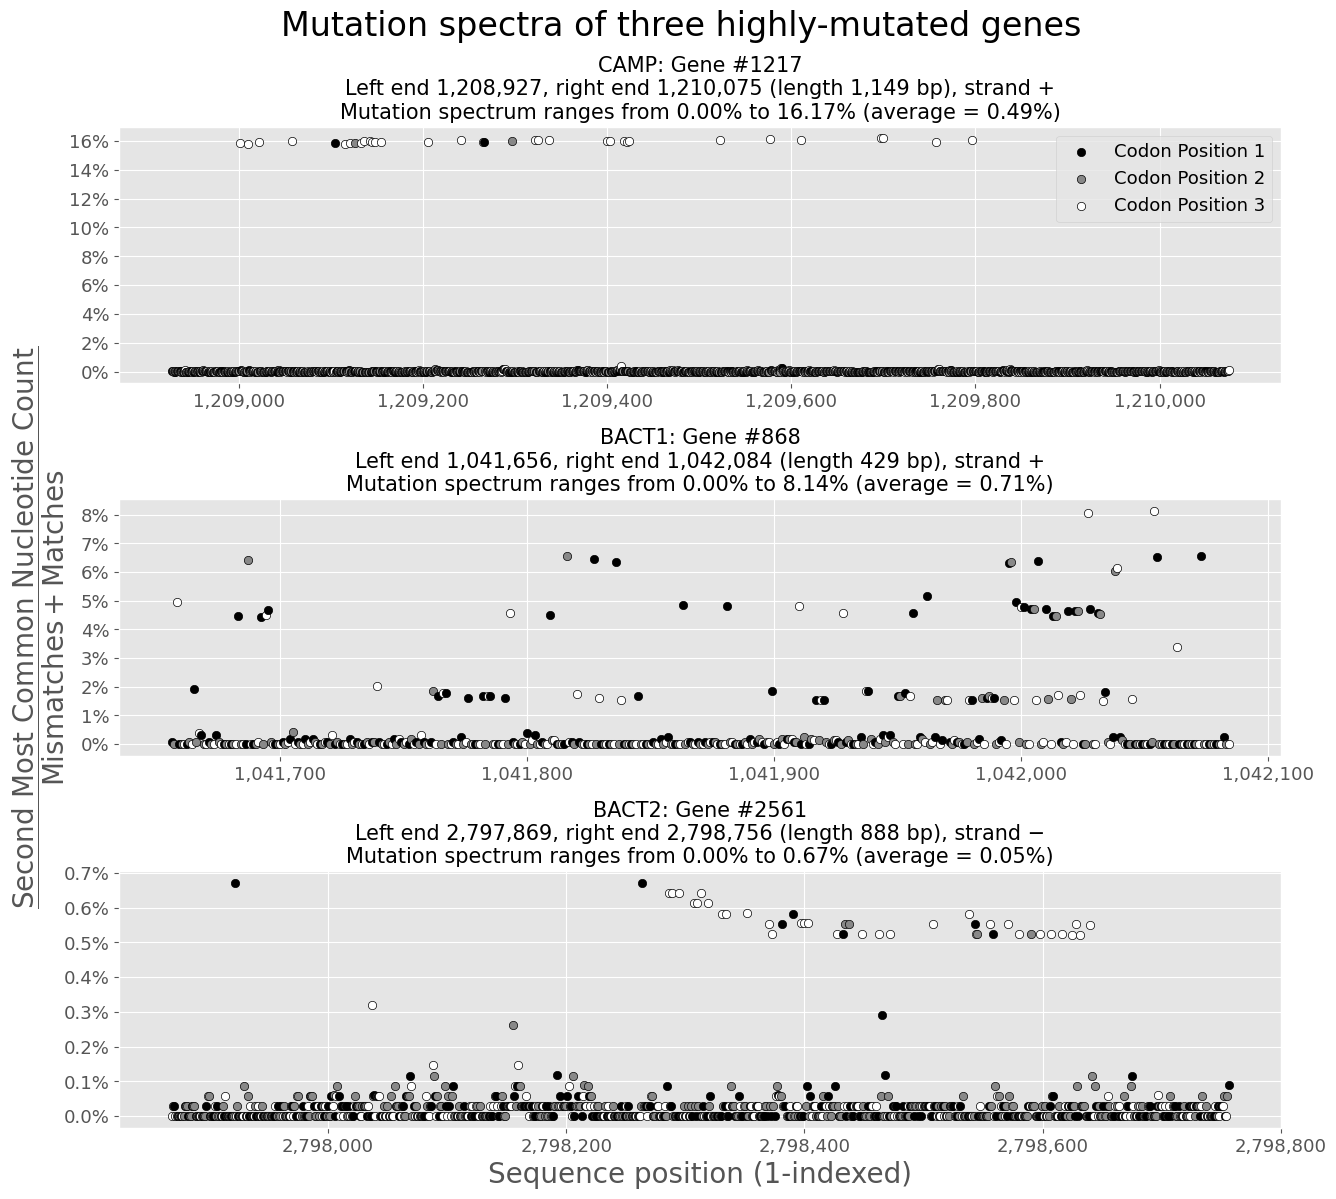

In [24]:
multi_gene_plots(hm_genes, "ms")

Maximum coverage is 4,570x
Maximum coverage is 1,341x
Maximum coverage is 3,451x


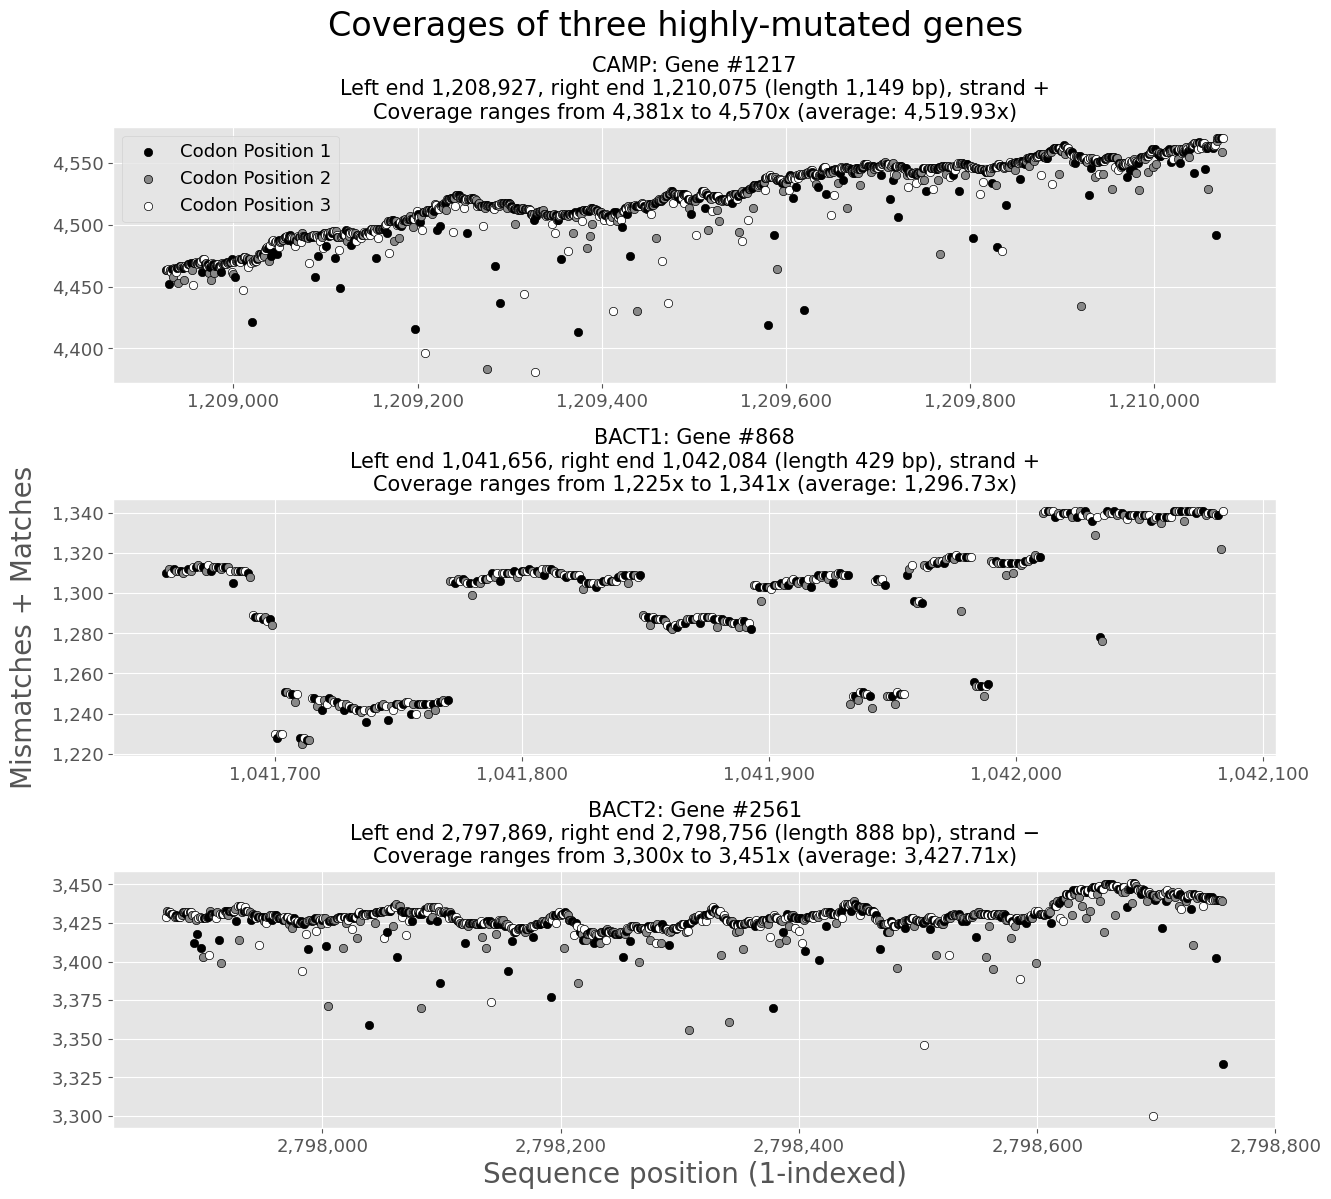

In [25]:
multi_gene_plots(hm_genes, "cov")